In [1]:
%matplotlib inline
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

# Character level N-gram Language Model
In the creation of this notebook I was heavily unfluenced by the following sources:

[Ref 1] Andrej Karpathy, makemore
- https://github.com/karpathy/makemore

[Ref 2] Jurafsky and Martin, Speech and Language Processing, 
- https://web.stanford.edu/~jurafsky/slp3/ed3bookaug20_2024.pdf
- https://github.com/rain1024/slp2-pdf

[Ref 3] https://www.probabilitycourse.com/chapter8/8_2_3_max_likelihood_estimation.php

[Ref 4] https://ep-news.web.cern.ch/what-likelihood-function-and-how-it-used-particle-physics

## Brief Introduction
Predicting in general is a difficult task. Especially trying to predict the next word, subword, character or in general a token (piece of text could be as small as a character and as big as the whole corpus). In daily life we have situations where we can predict what's coming next in a sentence...
```
Could you get some lemons from the ...?
```
Obviously, in the example above the possibilities are not infinite `["shops", "Tesco's, "Some other shop name", ...]`. How do we make that prediction in our heads? Even better question how can we come up with a system that could do those predictions for us? All those questions are related to the natural language processing (NLP) specically language models (LMs) are machine learning models that predicts the upcoming tokens.

Why do we need to predict the next token?
1. We can build systems where speech-to-text and text-to-speech could be implemented
2. We can build systems where the typos and grammatical mistakes can easily be corrected.
3. More importantly, as an inherent part of the language, predicting the next word/sentence/paragraph means the previous information has become a knowledge and accordingly the coherent communication still goes on.

In this notebook we will be starting with the simplest kind of language model: the __n-gram__ language model.


## Character Level N-gram Language Models
In this section we will both investigate the theoretical and practical implementation of the N-gram language models, which will be working in the character level meaning that our language model's goal will be to predict the __next character__ for the given sequence of text since this will be one of the easiest applications to learn the inner dynamics of language models.

The name __gram__ comes from the Greek word grámma (γράμμα), meaning _something written_ or _a small unit_. An `N`-gram represents the sequence of characters i.e. 2-gram (or _bigram_) means 2 character sequence such as $(c_1,~ c_2)$. Similarly, 3-gram (or _trigram_) means 3 character sequence such as $(c_1,~c_2,~c_3)$. The term `N`-gram means that the model is probabilistic and that can estimate the new character based on the `N-1` previous characters $(c_1,~c_2,\cdots,~c_{N-1})$.

In general sense, our task of the prediction of the next chracter prediction can be represented as $P(c~|~h)$, where $c$ and $h$ represent the next character to be predicted and the history of the characters. For instance, we can try to predict the probability of the next character being `"a"` knowing that the previous character was `"n"` $P(\text{"a"}~|~\text{"n"})$.

- One way to estimate the probability $P(\text{"a"}~|~\text{"n"})$ is directly from relative frequency counts, meaning a very large corpus, count the number of times the character `"n"` is followed by `"a"`. We can answer the question: out of times we saw the history $h$, how many times was it followed by the character $c$.

- If we had a sufficiently large corpus, we could compute this count and estimate the probability. However, as the history grows, the number of possible contexts grows exponentially and we need increasingly more data to estimate the next character accurately and coherently, which is not an easy task. Hence, we need a more clever and efficient approach.

Let's define some notation:

Throughout this notebook we will use character as tokens. To represent the probability of a particular random variable $X_i$ taking the value `"n"` represented as $P(X_i = \text{"n"}) = P(\text{"n"})$.

We will represent the sequence of $n$ characters $(c_1,~c_2,~\cdots,~c_n)$ will be represented by the notation $(c_{1:n})$. Note that the order of the elements in this notation is important.

Also, the joint probability of each chracter in a sequence having a particular value $P(X_1 = c_1,~X_2=c_2,~\cdots,~X_n=c_n)$ will be represented by $P(c_{1:n})$.

### Calculating the Probabilities of Entire Sequences
How can we compute the probabilities of the entire sequences, $(c_1,~c_2,~\cdots,~c_n)$, $P(c_1 \cap c_2 \cap \cdots \cap c_n)$? The simplest thing we can do to use the **Bayes' theorem** to recursively calculate the joint probabilities. Bayes' theorem for drawing a single card from deck example could be applied to as follows:
\begin{equation*}
P(\text{Ace} \cap \text{black}) = \frac{P(\text{drawing a black Ace})}{P(\text{drawing a black card})} = \frac{P(\text{Ace} \cap \text{black})}{P(\text{black})}
\label{eq:1} \tag{1}
\end{equation*}

<p align="left">
  <img src="images/bayes_theorem.png" alt="Bayes' theorem" width="450"/>
</p>

#### Simple/Intuitive Example
Let's simplify the task and try to understand what's going on. Let's focus on how to calculate the same probability for 3 characters? What is the probability of the characters $(c_1,~c_2,~c_3)$ occuring sequentially?
\begin{equation*}
P(\text{the sequence} ~(c_1,~c_2,~c_3)~ \text{occurring in this order}) = P(c_1\cap c_2 \cap c_3) = ~?
\label{eq:2} \tag{2}
\end{equation*}

We already know that we can use Bayes' theorem to express the joint probability of $(c_1,~c_2,~c_3)$ occuring in terms of the probability that the character $c_3$ appearing after the sequence $(c_1,~c_2)$
\begin{equation*}
P(c_3~|~ c_1 \cap c_2) = \frac{P(c_1\cap c_2\cap c_3)}{P(c_1 \cap c_2)} \quad \text{or}\quad P(c_1\cap c_2\cap c_3) = P(c_3~|~ c_1 \cap c_2)\times P(c_1 \cap c_2)
\label{eq:3} \tag{3}
\end{equation*}

Similarly, we can ask what is the probability of the character $c_2$ occuring after $c_1$?
\begin{equation*}
P(c_2~|~c_1) = \frac{P(c_2 \cap c_1)}{P(c_1)} \quad \text{or}\quad P(c_2 \cap c_1) = P(c_2~|~c_1)\times P(c_1)
\label{eq:4} \tag{4}
\end{equation*}

If we combine the expressions $\eqref{eq:2}$, $\eqref{eq:3}$ and $\eqref{eq:4}$,
\begin{equation*}
P(c_1\cap c_2 \cap c_3) = P(c_3~|~ c_1 \cap c_2)\times P(c_2~|~c_1)\times P(c_1)
\label{eq:5} \tag{5}
\end{equation*}

Let's expand the same example into a case where we would like to calculate the probability of $(c_1,~c_2,~c_3,~c_4)$ exactly in the given order:

\begin{align*}
\text{Step 1:}\quad &P(c_1\cap c_2 \cap c_3 \cap c_4) = P(c_4~|~ c_1 \cap c_2 \cap c_3)\times P(c_1 \cap c_2 \cap c_3),\\
\text{Step 2:}\quad &P(c_1 \cap c_2 \cap c_3) = P(c_3~|~ c_1 \cap c_2)\times P(c_1 \cap c_2),\\
\text{Step 3:}\quad &P(c_1 \cap c_2) = P(c_2~|~ c_1)\times P(c_1)
\end{align*}

Now, if we combine all the steps together

\begin{align*}
&P(c_1\cap c_2 \cap c_3 \cap c_4) = P(c_4~|~ c_1 \cap c_2 \cap c_3)\times P(c_3~|~ c_1 \cap c_2)\times P(c_2~|~ c_1)\times P(c_1)
\label{eq:6} \tag{6}
\end{align*}

As can be seen from above there is a nice pattern, which can be simplified as,

\begin{equation*}
P(c_1,~c_2,~\cdots,~c_n) = \prod_{k=1}^{n} P(c_k~|~ c_{1:k-1})
\label{eq:7} \tag{7}
\end{equation*}

The above expression gives us the link between the joint probabilty of a particular sequence and computing the conditional probability of the next character given previous characters.

- Please note from the above expression that the we can calculate the probability of a particular sequence occuring, $P(c_1,~c_2,~\cdots,~,c_n)$ as long as if we can calculate the conditional probability, $P(c_k~|~ c_{1:k-1})$ for each $k$. Unfortunately, we don't have any way to calculate the expression $P(c_k~|~ c_{1:k-1})$.

- As an additional note we can't just count the number of occurences of each character sequence with varying length since the number of possible combinations for a character sequence with lengh $N$ ($N$-gram) becomes $29^N$, since we will see shortly that we have $29$ characters in the Turkish alphabet, which becomes infeasible too quickly due to the highly exponential nature. Moreover, some particular sequences might have not been occured in the training corpus before!

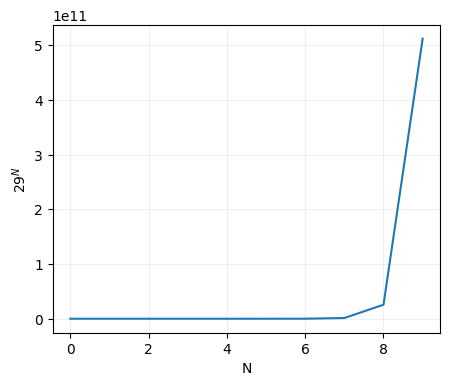

In [2]:
N = np.arange(0, 10)
fig = plt.figure(figsize=(5, 4))
plt.plot(N, 20**N)
plt.xlabel("N")
plt.ylabel("$29^{N}$")
plt.grid(True, alpha=0.2)
plt.show()

### The Markov Assumption
The intiutiton of an $N$-gram model is that instead of computing the probability of the next character being, $c$, given its entire history, $h$, we can **approximate** the history by using just a few last characters. In other words, instead of solving the following:

\begin{equation*}
P(c_1,~c_2,~\cdots,~c_n) = \prod_{k=1}^{n} P(c_k~|~ c_{1:k-1})
\label{eq:8} \tag{8}
\end{equation*}

#### Bigram Model
We can try to make the following approximation:

\begin{equation*}
P(c_1,~c_2,~\cdots,~c_n) = \prod_{k=1}^{n} P(c_k~|~ c_{k-1})
\label{eq:9} \tag{9}
\end{equation*}

In other words, we can approximate the probability $P(c_k~|~ c_{1:k-1})$, which is really hard to compute we can just use $P(c_k~|~ c_{k-1})$, where we know that we can calculate $P(c_k~|~ c_{k-1})$ much easier by just counting the bigrams ($N=2$) in the corpus.

#### Unigram Model
We can go one more notch further and assume that no history is involved in our decisions,
\begin{equation*}
P(c_1,~c_2,~\cdots,~c_n) = \prod_{k=1}^{n} P(c_k)
\label{eq:10} \tag{10}
\end{equation*}

#### Simple Example
**Markov assumption** or **Markov property** can be explained with the following example:

Assume we have a jar contains two red (2xR) and one a green (G) ball.
<p align="left">
  <img src="images/markov_assumption.png" alt="Bayes' theorem" width="250"/>
</p>

- One ball was drawn yesterday.
- One ball was drawn today.
- The final ball will be drawn tomorrow. All the draws are **without replacement**.

Suppose you know that today's ballwas **red**, but yout have no information about yesterday's ball. What can we infer about the tomorrow's ball $P(\text{drawing } R \text{ tomorrow})$?
| Today | Tomorrow     |
|-------|--------------|
|   R   | $P(R) = 0.5$ |
|   G   | $P(R) = 1$   |

If we knew what has been drawn yesterday, how would $P(\text{drawing } R \text{ tomorrow})$ change?

| Yesterday   | Today | Tomorrow    |
|-------------|-------|-------------|
| If it was R |   R   | $P(R) = 0$  |
| If it was R |   G   | $P(R) = 1$  |
| If it was G |   R   | $P(R) = 1$  |

The experiment above shows that the probability distribution for **tomorrow's color not only depends on the present value but is also information about the past**. The probability density function (pdf) is changing when we have more information about yesterdays draw. In order to understand underlying mathematics we will need to understand conditional probabilities.

##### Bayes' Theorem
Let's try to calculate the probability of drawing an ace and a card which is black:

\begin{align*}
P(\text{Ace}) &= \frac{\text{number of aces}}{\text{number of cards}} = 4/52 = 1/13 \\ \\
P(\text{Black}) &= \frac{\text{number of blacks}}{\text{number of cards}} =  13/52 = 1/4 \\ \\
P(\text{Black and Ace}) &= P(\text{Ace and Black}) = \frac{\text{number of black Aces}}{\text{number of cards}} = 1/52
\label{eq:11} \tag{11}
\end{align*}

How can we calculate the following probability? $P(\text{Ace given that we already have a black card})$? 

Since we know that we have a black card:
\begin{equation*}
P(\text{Ace given we've drawn a black card}) = P(\text{Ace}~|~\text{black}) = \frac{\text{number of black aces}}{\text{number of blacks}} = \frac{1}{13}
\label{eq:12} \tag{12}
\end{equation*}
The above expression $(\text{number of black aces})/(\text{number of blacks})$ could also be calculated using $\eqref{eq:12}$ as follows:

\begin{align*}
P(\text{Ace given we've drawn a black card}) = \frac{\text{number of black aces}}{\text{number of blacks}} = \frac{P(\text{Black and Ace})\times (\text{number of cards})}{P(\text{Black})\times(\text{number of cards})} = \frac{P(\text{Black and ace})}{P(\text{Black})}
\end{align*}
Thus,
\begin{align*}
P(\text{Ace}~|~\text{Black}) = \frac{P(\text{Black and ace})}{P(\text{Black})}
\label{eq:13} \tag{13}
\end{align*}

#### The Markov Property Continues
Since we've learnt about the conditional probabilities and Bayes' theorem. We can continue investigating the Markov property and related probabilities.
<p align="left">
  <img src="images/markov_assumption_2.png" alt="Bayes' theorem" width="350"/>
</p>
We know that if the experiment was done with replacement, the probabilities would be equal for tomorrow's draw, where today's and yesterday's draws would be irrelevant. In other words, draws would be independent and Markov property would be satisfied.
\begin{align*}
&P(G\text{ tomorrow}) = 1/3\\
&P(R\text{ tomorrow}) = 1/3 + 1/3 = 2/3
\end{align*}

However, when we have an experiment without replacement, draws are not independent and the Markov property is not getting satisfied. The above diagram summarizes the jar with three balls without replacement experiment. We can also express the probabilities using the conditional probabilities as follows:
\begin{align*}
&P(R\text{ tomorrow}~|~(R\text{ yesterday},~R\text{ today}) = 0\\
&P(R\text{ tomorrow}~|~(R\text{ yesterday},~G\text{ today})) = 1\\
&P(R\text{ tomorrow}~|~(G\text{ yesterday},~R\text{ today}) =1\\ \\
&P(R\text{ today}~|~R\text{ yesterday}) = 1/2 \\
&P(R\text{ today}~|~G\text{ yesterday}) = 1 \\ \\
&P(R\text{ tomorrow}) = 2/3 \\
&P(G\text{ tomorrow}) = 1/3
\end{align*}

#### N-gram Model

It is important to emphasize that even though the probability of some character sequence occuring is completely dependent on the whole _history_ for the simplification and approximation purposes we can assume that Markov property holds and only information we need is only $N-1$ steps in $N$-gram models. For instance, for a bigram model ($N=2$) with $n=5$ characters becomes, 
\begin{align*}
P(c_1,~c_2,~c_3,~c_4,~c_5) &= P\big(c_5~|~(c_1,~c_2,~c_3,~c_4)\big)\times P\big(c_4~|~(c_1,~c_2,~c_3)\big)\times P\big(c_3~|~(c_1,~c_2)\big)\times P(c_2~|~c_1)\times P(c_1) \\
&\approx P(c_5~|~c_4)\times P(c_4~|~c_3)\times P(c_3~|~c_2)\times P(c_2~|~c_1)\times P(c_1)
\label{eq:14} \tag{14}
\end{align*}

Let's do another example for $n=5$ and $N=3$,
\begin{align*}
P(c_1,~c_2,~c_3,c_4,~c_5) \approx P\big(c_5~|~(c_3,~c_4)\big)\times P\big(c_4~|~(c_2,~c_3)\big)\times P(c_2~|~c_1)\times P(c_1)  
\label{eq:15}\tag{15}
\end{align*}

If we generalize the expressions \eqref{eq:14} and \eqref{eq:15},
\begin{align*}
P(c_1,~c_2,c_3,~c_4,\cdots,~c_n) \approx \prod_{k=1}^{n}P(c_k~|~c_{k-N+1:k-1})
\label{eq:16} \tag{16}
\end{align*}

##### How to Estimate the Probabilities?
Now, we've obtained a simpler and more computable version of the \eqref{eq:8} in \eqref{eq:15}. However, another issue still exists. How will we calculate the probabilities $P(c_k~|~c_{k-N+1:k-1}$ or $P\big(c_k~|~(c_{k-2},~c_{k-1})\big)$ for $N=2$?

An intuitive way to estimate the probabilities is the *maximum likelihoode estimation (MLE)*. Accordingly, we can get the MLE estimates of the parameters if the $N$-gram model is the getting the counts from the corpus, and **normalizing** the counts so that they lie between $0$ and $1$. In other words, once normalized the counts could be used as the **probability distributions**.

## Lab: Turkish Names Dataset
Let's implement everything we've learnt so far using the Turkish names dataset to generate some Turkish names.

In [3]:
with open("./data/turkce_isim_veri_seti/tr_isimler.txt", "r", encoding="utf-8") as file:
    text = file.read()
text[:100]

'hüsne\nbasiri\nsibel\nyekta\nmahpeyker\nufkun\nburha\nümmü\nebrar\nnursel\naykut\nanıl\nşahvelet\nsadettin\nuçar\nb'

Let's parse the input in a way that the line break operator (`\n`) is getting processed:

In [4]:
text = re.split(r"\n", text)
text[:10]

['hüsne',
 'basiri',
 'sibel',
 'yekta',
 'mahpeyker',
 'ufkun',
 'burha',
 'ümmü',
 'ebrar',
 'nursel']

Let's get some insights about the Turkish names:

In [5]:
length_name = {name:len(name) for name in text}
length_name = dict(sorted(length_name.items(), key=lambda item:item[1], reverse=True))
max_length = max(length_name.values())
min_length = min(length_name.values())
mean_length = sum(length_name.values()) / len(length_name.values())

In [6]:
print(f"Longest names ({max_length} characters): {[name for name in length_name.keys() if len(name) == max_length]}")
print(f"Shortest names ({min_length} characters): {[name for name in length_name.keys() if len(name) == min_length]}")
print(f"Average length: {mean_length:.2f} characters")
print(f"Number of unique names: {len(list(set(length_name.keys())))}")

Longest names (13 characters): ['abdulmuttalip', 'sebahittincan']
Shortest names (2 characters): ['su', 'iz']
Average length: 5.88 characters
Number of unique names: 2315


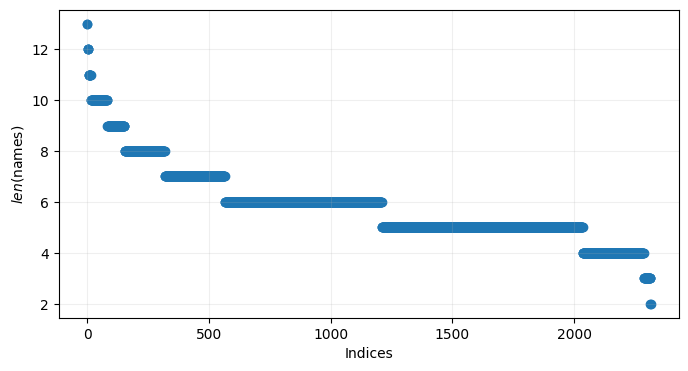

In [7]:
fig = plt.figure(figsize=(8, 4))
plt.scatter(range(len(length_name.values())), length_name.values())
plt.xlabel(r"Indices")
plt.ylabel(r"$len(\text{names})$")
plt.grid(visible=True, alpha=0.2)
plt.show()

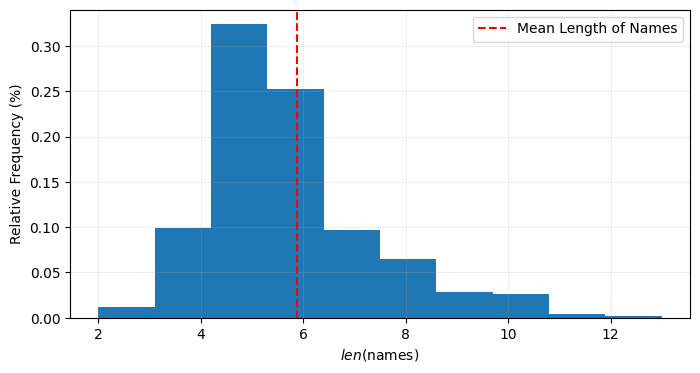

In [8]:
length_count = [v for k,v in length_name.items()]

fig = plt.figure(figsize=(8, 4))
plt.hist(length_count, density=True)
plt.axvline(mean_length, color='red', linestyle='--', label="Mean Length of Names")
plt.xlabel(r"$len(\text{names})$")
plt.ylabel("Relative Frequency (%)")
plt.grid(visible=True, alpha=0.2)
plt.legend()
plt.show()

#### Idea Behind the Likelihood and Maximum Likelihood Estimation (MLE)
Let's take a very simple example of a coin toss. The coin could either land on heads (T) or tails (T). Let's assume that we are interested in estimating the number of H in 4 trials, which will be represented using the letter $\theta$, where we know that $\theta \in \{ 0, 1, 2, 3, 4\}$. This example is very similar to our previous drawing ball example *with replacement*. We will define the probability of observing H, which is called *Bernoulli distribution* for each trial using the random variable $X_i$, where $i\in \{ 1,2,3,4 \}$.
\begin{align*}
X_i =
\begin{cases}
    p, & \text{$i^\text{th}$ trial being heads (H)}, \\
    q \text{ or }1-p, & \text{$i^\text{th}$ trial being tails (T)}
\end{cases}
\label{eq:17} \tag{17}
\end{align*}

where $p$ represents the probability of observing H in each draw ($0\leq p \leq 1$). Note that $X_i$'s are independent and identically distributed (i.i.d).

Let's assume after 4 trials the following is what we observe:
\begin{align*}
(x_1,~x_2,~x_3,~x_4) = (\text{H},~\text{T},~\text{H},~\text{H}) = (1,~0,~1,~1)
\end{align*}

1. Can we estimate the probability of observing $(1,~0,~1,~1)$ or for each $\theta$?
2. Similarly, for which value of $\theta$, the probability of observing $(1,~0,~1,~1)$ is maximum?

Let's investigate the first item. The following are the whole probability space:
1.  (H, H, H, H) or [1, 1, 1, 1] $\rightarrow~\theta = 4$
2.  (H, H, H, T) or [1, 1, 1, 0] $\rightarrow~\theta = 3$
3.  (H, H, T, H) or [1, 1, 0, 1] $\rightarrow~\theta = 3$
4.  (H, H, T, T) or [1, 1, 0, 0] $\rightarrow~\theta = 2$
5.  (H, T, H, H) or [1, 0, 1, 1] $\rightarrow~\theta = 3$
6.  (H, T, H, T) or [1, 0, 1, 0] $\rightarrow~\theta = 2$
7.  (H, T, T, H) or [1, 0, 0, 1] $\rightarrow~\theta = 2$
8.  (H, T, T, T) or [1, 0, 0, 0] $\rightarrow~\theta = 1$
9.  (T, H, H, H) or [0, 1, 1, 1] $\rightarrow~\theta = 2$
10. (T, H, H, T) or [0, 1, 1, 0] $\rightarrow~\theta = 2$
11. (T, H, T, H) or [0, 1, 0, 1] $\rightarrow~\theta = 2$
12. (T, H, T, T) or [0, 1, 0, 0] $\rightarrow~\theta = 1$
13. (T, T, H, H) or [0, 0, 1, 1] $\rightarrow~\theta = 2$
14. (T, T, H, T) or [0, 0, 1, 0] $\rightarrow~\theta = 1$
15. (T, T, T, H) or [0, 0, 0, 1] $\rightarrow~\theta = 1$
16. (T, T, T, T) or [0, 0, 0, 0] $\rightarrow~\theta = 0$

In summary,
- $N({\theta = 0}) = \binom{4}{0} = 1$ and $P(k=0) = 1/16$
- $N({\theta = 1}) = \binom{4}{1} = 4$ and $P(k=1) = 4/16$
- $N({\theta = 2}) = \binom{4}{2} = 6$ and $P(k=2) = 6/16$
- $N({\theta = 3}) = \binom{4}{3} = 4$ and $P(k=3) = 4/16$
- $N({\theta = 4}) = \binom{4}{4} = 1$ and $P(k=4) = 1/16$

where $N(\cdot)$ represents the number of instances for the given case.

Let's count the R occurences plot the occurence frequency against $k$,

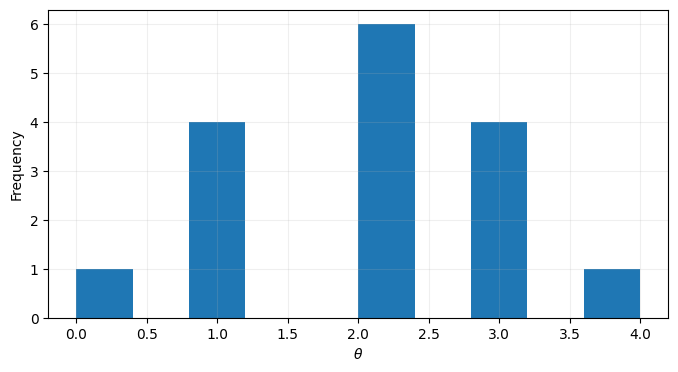

In [9]:
probs = np.array([
                [1, 1, 1, 1], 
                [1, 1, 1, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 1],
                [1, 1, 0, 0], [1, 0, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1], 
                [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1],
                [0, 0, 0, 0]
                ])
k = np.sum(probs, axis=1)
fig = plt.figure(figsize=(8, 4))
plt.hist(k)
plt.xlabel(r"$\theta$")
plt.ylabel("Frequency")
plt.grid(alpha=0.2)
plt.show()

If the probability of having heads and tails are both equal, $P(H)=P(T)=0.5$, we can make the following deductions:

1. We can estimate the probability of observing $(1,~0,~1,~1)$ or $(\text{H},~\text{T},~\text{H},~\text{H})$, since we have an i.i.d random variable,
\begin{align}
P(\text{H and T and H and H}) = P(\text{H})\times P(\text{T})\times P(\text{H})\times P(\text{H}) = p^3\cdot(1-p)
\end{align}

2. We can also estimate the probability of having 3 heads in 4 trials for the generalized scenario:
\begin{align}
P(\text{3 heads in 4 trials}) = P(\text{1 tails in 4 trials}) = P\big((\text{H,H,H,T}) \cup (\text{H,H,T,H}) \cup (\text{H,T,H,H}) \cup (\text{T,H,H,H})\big)
\end{align}

Since each our independent trials are mutually exclusive (meaning that for instance (H, H, H, T) and (H, T, H, H) cannot happen at the same time, $P\big((\text{H,H,H,T}) \cap (\text{H,H,T,H})\big)=0$,
\begin{align}
P(\text{3 heads in 4 trials}) = P(\text{1 tails in 4 trials}) = P(\text{H,H,H,T}) + P(\text{H,H,T,H}) + P(\text{H,T,H,H}) + P(\text{T,H,H,H}))
\end{align}

Similarly, we can calculate the probabilities in the above expression for $k$ heads and $n$ trials (or $(n-k)$ tails) as $P(\text{H},\cdots,\text{H},\text{T},\cdots,\text{T}) = p^k\cdot q^{n-k} = p^k\cdot (1-p)^{n-k}$. Thus, we can calculate the most generalized version $P(\theta=k~|~p)$ as follows:
\begin{align}
P(\theta=k~|~p) = \binom{n}{k}p^k(1-p)^{n-k}
\label{eq:18}\tag{18}
\end{align}

#### Statistical Models and Likelihood Function
It is important to note that we also have a similar function called *likelihood function*, which measures how plausible an event is. In likelihood function calculation, we treat the data (which could be collected or measured data) as fixed, $x$. We evaluate the expression $P(x~|~\theta)$ only for the specific $x$ that was observed and examine how it varies as $\theta$ changes. The model parameters $\theta$, for example in CERN calculations, represent the constants of nature in putative or speculative laws of physics and the response of detectors. The data, $x$, stand for an arbitrarily large collection of observations such as tracks of particles in the ATLAS or CMS detectors.

Even if all values of $\theta$ are kept fixed, the observations $x$ will exhibit intrinsic variability—either because of slight changes in conditions or, more fundamentally, because of the randomness in the quantum-mechanical laws that govern particle interactions and lead to statistical fluctuations. Therefore, statistical models, usually written in the form of $P(x~|~\theta)$ or $P(x~;~\theta)$, are not deterministic equations but rather probabilities or probability density functions (pdfs) describing the likelihood of obtaining various $x$ given a set of parameters $\theta$.

Experiments provide observations of $x$, which scientists use to make inferences about components of $\theta$ (for example, the mass of the Higgs boson) or about the form of $p$ itself (such as whether the Higgs boson or other not-yet-observed particles exist).

- Probability answers the following question:
> If we knew $p$, what is the chance of getting this particular event (e.g. 3 heads in 4 trials)?
> Thus, if $p=0.7$, the probability of seeing exactly 3 heads out of 4 trials:

\begin{align*}
P(\theta~|~p=0.7) = \binom{4}{\theta}\cdot (0.7)^\theta\cdot (0.3)^{n-\theta}
\end{align*}
we can see from the above expression that the probability is the funcation of $\theta$ when $p$ is fixed.
- Likelihood answers the following question:
> Given the data we observe, how likely each possible value of $p$?
> So, we treat the data, $\theta$, as fixed and we look at the function of $p$:

\begin{align*}
\mathcal{L}(p) = P(\theta=3~|~p) = \binom{4}{3}\cdot p^3\cdot (1-p)^{n-3}
\end{align*}

Generalized form of the likehood function becomes, 
\begin{align*}
\mathcal{L}(p) = \binom{n}{k} p^k \cdot q^{n-k} = p^k \cdot (1-p)^{n-k}
\end{align*}

##### Plotting the likelihood against $p$
Let's evaluate the above likelihood definition with respect to (w.r.t) probability of R occuring ($p$),

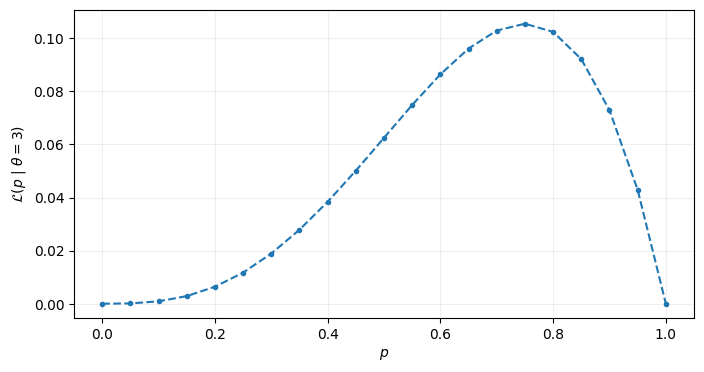

In [10]:
p = np.append(np.arange(0, 1, 0.05), 1)
L = (p ** 3)*(1-p)

fig = plt.figure(figsize=(8, 4))
plt.plot(p, L, 'o--', markersize=3)
plt.xlabel("$p$")
plt.ylabel(r"$\mathcal{L}(p~|~\theta=3)$")
plt.grid(alpha=0.2)
plt.show()

As we can see from the figure above, the likelihood function is increasingin the vicinity of $p=0.7$ then starts dropping again. Thus, the critical question is **what is the value that maximizes the likelihood function**? Or in mathematically,
\begin{align*}
\hat{p} = \arg\max_p \mathcal{L(p)} = ? 
\end{align*}

For independent Bernoulli trials, maximization of the likelihood of observing $\theta$ heads using \eqref{eq:18} becomes,
\begin{align*}
\hat{p} = \arg\max_p\left( p^\theta\cdot (1-p)^{n-\theta} \right)
\end{align*}
Solving the above expression is not simple, however, we can use some optimization tricks e.g, we know that the logarithm is a monotonically increasing function for positive values like $p$, where $0\leq p \leq 1$,

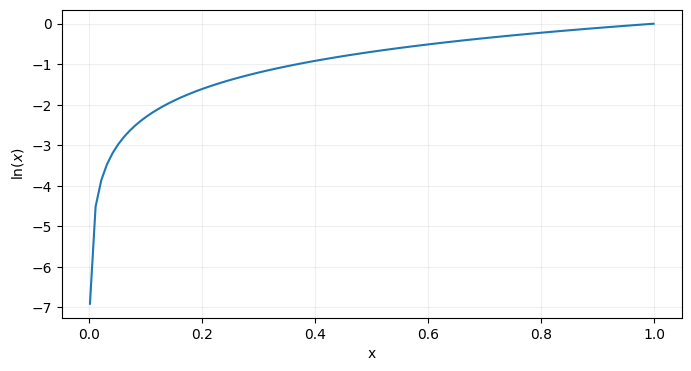

In [11]:
x = np.append(np.arange(1e-3, 1, 0.01), 1-1e-3)
y = np.log(x)
fig = plt.figure(figsize=(8, 4))
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("$\ln(x)$")
plt.grid(alpha=0.2)
plt.show()

Therefore, we can say that the maximizing $x$ is same task as maximizing the function $\ln(x)$, which effectively means, that we will be trying to maximize the log-likelihood function, $\ln\big( \mathcal{L}(p) \big)$,
\begin{align*}
\hat{p} &= \arg\max_p\bigg( \ln( p^\theta\cdot (1-p)^{n-\theta} ) \bigg) = \arg\max_p\bigg( \ln(p^\theta) + \ln\left((1-p)^{n-\theta}\right) \bigg) \\ 
&= \arg\max_p\bigg( \theta\ln(p) + (n-\theta)\ln(1-p) \bigg)
\label{eq:19}\tag{19}
\end{align*}

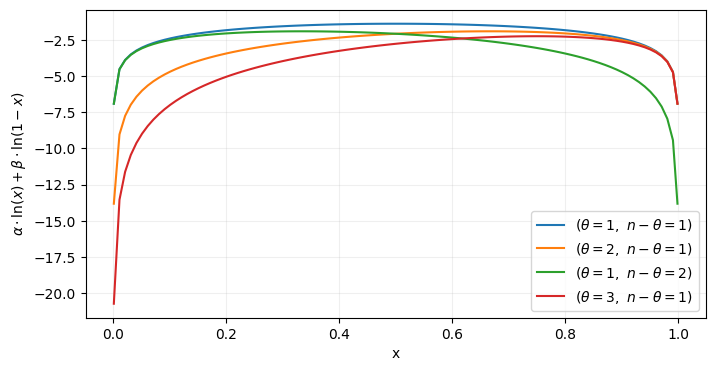

In [12]:
x = np.append(np.arange(1e-3, 1, 0.01), 1-1e-3)
y1 = np.log(x) + np.log(1-x)
y2 = 2*np.log(x) + np.log(1-x)
y3 = np.log(x) + 2*np.log(1-x)
y4 = 3*np.log(x) + np.log(1-x)

fig = plt.figure(figsize=(8, 4))
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)
plt.xlabel("x")
plt.ylabel(r"$\alpha\cdot\ln(x)+\beta\cdot\ln(1-x)$")
plt.grid(alpha=0.2)
plt.legend([r"$(\theta=1,~n-\theta=1)$", r"$(\theta=2,~n-\theta=1)$", r"$(\theta=1,~n-\theta=2)$", r"$(\theta=3,~n-\theta=1)$"])
plt.show()

The expression in \eqref{eq:19} can also be represented as follows:

\begin{align*}
\hat{p} &= \arg\max_p\bigg( \theta\ln(p) + (n-\theta)\ln(1-p) \bigg) \\
&\equiv \arg\min_p\bigg( -\theta\ln(p) - (n-\theta)\ln(1-p) \bigg)
\label{eq:20}\tag{20}
\end{align*}

We can see that the finding the value that would maximize the likelihood function is equivalent to minimizing the negated likelihood function. Furthermore, we can find the value that maximizes likelihood function by taking the derivative and setting it to zero,
\begin{align*}
\hat{p} &\equiv \frac{\partial \big( -\theta\ln(p) \big)}{\partial p} - \frac{\partial\big( (n-\theta)\ln(1-p) \big)}{\partial p} = 0 \\
&= -\frac{1}{p}\cdot \theta - (n-\theta)\cdot \frac{1}{1-p} = 0 \\
&\Rightarrow -\frac{\theta}{p} = \frac{n-\theta}{1-p} \\
&\Rightarrow pn - p\theta = \theta - \theta p \\
&\Rightarrow \boxed{p = \frac{\theta}{n}}
\label{eq:21}\tag{21}
\end{align*}

Consequently, we can infer from \eqref{eq:20} that the $p$ value that maximizes the likelihood becomes, $\hat{p}=3/4=0.75$.

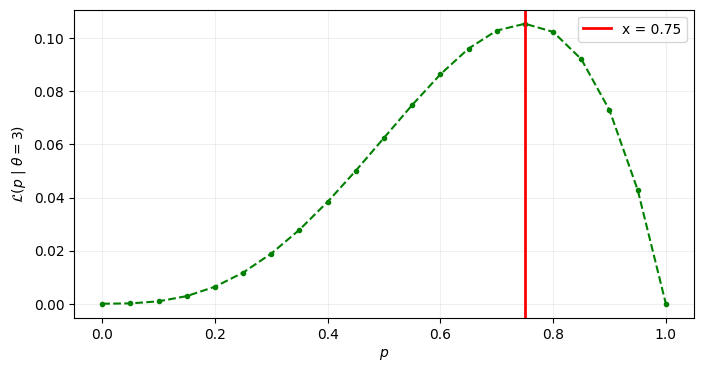

In [13]:
p = np.append(np.arange(0, 1, 0.05), 1)
L = (p ** 3)*(1-p)

fig = plt.figure(figsize=(8, 4))
plt.plot(p, L, 'go--', markersize=3)
plt.axvline(x=0.75, color='r', linewidth=2, label='x = 0.75')
plt.xlabel("$p$")
plt.ylabel(r"$\mathcal{L}(p~|~\theta=3)$")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

Let's investigate the behaviour of the likelihood function for $\theta \in \{ 0, 1, 2, 3\}$ when $n=4$,

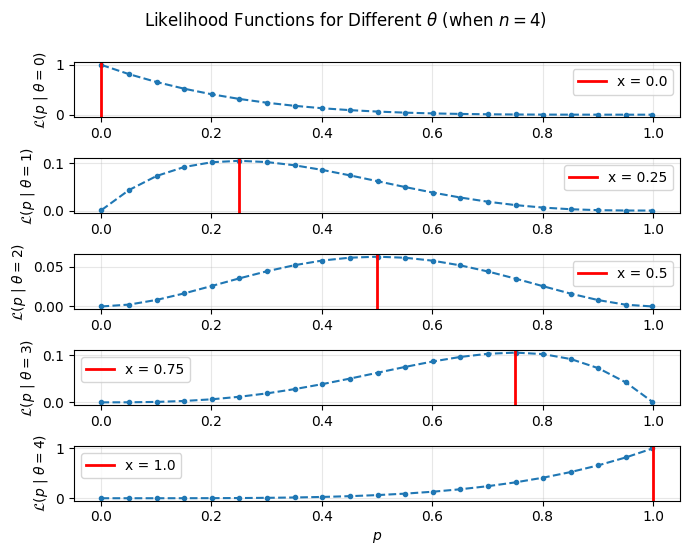

In [14]:
p = np.append(np.arange(0+1e-3, 1, 0.05), 1-1e-3)
L0 = (p ** 0)*((1-p) ** 4)
L1 = (p ** 1)*((1-p) ** 3)
L2 = (p ** 2)*((1-p) ** 2)
L3 = (p ** 3)*((1-p) ** 1)
L4 = (p ** 4)*((1-p) ** 0)
Ls = [L0, L1, L2, L3, L4]

fig, axes = plt.subplots(5, 1, figsize=(7,5.5))
for i, ax in enumerate(axes):
    ax.plot(p, Ls[i], 'o--', markersize=3)
    ax.axvline(x=i/4, color='r', linewidth=2, label=f"x = {i/4}")
    ax.set_ylabel(fr"$\mathcal{{L}}(p~|~\theta={i})$")
    ax.grid(alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("$p$")
fig.suptitle(r"Likelihood Functions for Different $\theta$ (when $n=4$)", y=1)
plt.tight_layout()
plt.show()

- Here, we've confirmed that the likelihood function could be maximized for a given $p$ and $\theta$ value.
- The value that maximizes the likelihood function corresponds to the **maximum likelihood estimation (MLE)**.

## Estimating the Probabilities of $N$-grams

So far we've seen the Markov assumption and the concepts likelihood, maximum likelihood (ML) and maximum likelihood estimation (MLE). The main question is how can we estimate the bigram probabilities? An intiutive way is as follows:
- Estimate the probabilities of an $N$-gram model using MLE from the the corpus.
- **Normalizing** those counts so that the sum of the counts lie between 0 and 1, which we essentially can treat as probabilities.

### Simple Bigram Example

Let's take the following input as our sequence to investigate the MLE estimation for bigrams.

Let's assume our corpus `yxxyyxxxyx`, with an alphabet of $\mathcal{A}\in \{ x, ~y\}$.

- The unigram counting operation, $\mathcal{C}(c)$, counts total number of times the character `c` appears **anywhere** in the corpus, where $\mathcal{C}(x) = 6$ and $\mathcal{C}(y) = 4$.

- We can go one more level and count the bigram frequencies from the corpus:
    - The character bigrams from the corpus above becomes, `["yx", "xx", "xy", "yy", "yx", "xx", "xx", "xy", "yx"]`

    - Thus, the bigram frequencies are $\mathcal{C}(yx) = 3$, $\mathcal{C}(xx) = 3$, $\mathcal{C}(xy) = 2$, $\mathcal{C}(yy) = 1$.
 
- We can also calculate the character probabilities,
\begin{align}
P(\text{character } y \text{ occuring}) = P(y) = \frac{\mathcal{C}(y)}{\sum_{c\in\mathcal{A}}\mathcal{C}(c)}, ~~ \text{and} ~~ P(\text{character } x \text{ occuring}) = P(x) = \frac{\mathcal{C}(x)}{\sum_{c\in \mathcal{A}}\mathcal{C}(c)}, ~~ \text{where } \mathcal{A}\in\{ x,~y \}
\end{align}

- Similarly, we can calculate the bigram probabilities as follows:
\begin{align}
P(x\text{ comes after }y) = P(x~|~y) = P(yx) = \frac{\mathcal{C}(yx)}{\sum_{c\in \mathcal{A}}\mathcal{C}(yc)}, ~~ \text{where } c\in\{ x,~y \}
\end{align}


- We can easily see from the above equations that in bigram analysis we are pairing up characters and calculate the bigram frequencies.

As a result of pairing, the characters at the *beginning* and *end* of the corpus considered only once as opposed to twice (position 1 and position 2) like the other characters. Let's take an example where the character $\hat{c}$ only appears at the end of the corpus only. The bigram count, $\mathcal{C}(\hat{c}c)$ for $c\in \mathcal{A}$, will be $0$ for the character $\hat{c}$, however, this case will be counted in the calculation of $\mathcal{C}(\hat{c})$. The important consequence of this is that the following expression:
\begin{align}
\sum_{c\in \mathcal{A}}\mathcal{C}(\hat{c}c) \neq \mathcal{C}(\hat{c}),
\label{eq:22}\tag{22}
\end{align}
which breaks the probability rules.

For instance, if we use our simple example above, $P(yx) = 3/4 = 0.75$, $P(xx) = 3/5 = 0.6$, $P(xy) = 2/5 = 0.4, P(yy) = 1/4 = 0.25$. However, the actual probabilities should have been, $P(yx) = 3/4 = 0.75$, $P(xx) = 3/6 = 0.5$, $P(xy) = 2/6 \approx 0.33$, $P(yy) = 1/4 = 0.25$.

Note from above probabilities that the problem occurs due to difference, $\sum_{c\mathcal{A}}C(xc) = \mathcal{C}(xx) + \mathcal{C}(xy) = 5$, whereas $\mathcal{C}(x) = 6$. Similarly, if we calculate $\sum_{c\mathcal{A}}C(cy) = \mathcal{C}(xy) + \mathcal{C}(yy) = 3$, whereas $\mathcal{C}(y) = 4$.

### Why do we need start and end of sequence tokens?

One way to keep the probability rules intact for the sake of our statistical modelling approach, we can introduce a start (`<BAS>` from the Turkish word "başlangıç") and end (`<BIT>` from the Turkish word "bitiş") tokens could be introduced. Accordingly, the corpus for our simple example becomes, `<BAS>yxxyyxxxyx<BIT>`. Now, if we split the bigrams for this corpus we will obtain the following

- Bigrams: `["<BAS>y", "yx", "xx", "xy", "yy", "yx", "xx", "xx", "xy", "yx", "x<BIT>"]`. We can see that two more bigrams have been added to our bigrams list.

- If we calculate the bigram frequencies: $\mathcal{C}(\texttt{<BAS>}y) = 1$, $\mathcal{C}(yx) = 3$, $\mathcal{C}(xx) = 3$, $\mathcal{C}(xy) = 2$, $\mathcal{C}(yy) = 1$, $\mathcal{C}(x\texttt{<BIT>}) = 1$.

- If we check the probabilities now, $\sum_{c\mathcal{A}}C(xc) = \mathcal{C}(xx) + \mathcal{C}(xy) + \mathcal{C}(x\texttt{<BIT>}) = 6$, where $\mathcal{C}(x) = 6$. Similarly, $\sum_{c\mathcal{A}}C(cy) = \mathcal{C}(xy) + \mathcal{C}(yy) + \mathcal{C}(\texttt{<BAS>y}) = 4$, where $\mathcal{C}(y) = 4$. **Therefore, our usual probabilit rules apply after the introduction of the start and end tokens**.

- A final remark: if we represent the bigram frequencies as a two-dimensional matrix, each cell indicates how many times the column character follows the row character, as shown below.
\begin{array}{c|ccccc}
   & \texttt{<BAS>} & \text{x} & \text{y} & \texttt{<BIT>} \\
  \hline
  \texttt{<BAS>} & 0 & 0 & 1 & 0 \\
  \text{x} & 0 & 3 & 2 & 1 \\
  \text{y} & 0 & 3 & 1 & 0 \\
  \texttt{<BIT>} & 0 & 0 & 0 & 0
\end{array}
The main problem with the above table is that there won't be any bigrams that are ending with $\texttt{<BAS>}$, or similarly starting with $\texttt{<BIT>}$. Hence, the first row and column will always be empty.

**Can we find a better start/end token insertion that would alleviate this issue?**

A good solution to the above question is using the same token for both start and end tokens such as `●`. If we update the bigram counts matrix,
\begin{array}{c|ccccc}
   & ● & \text{x} & \text{y} \\
  \hline
  ● & 0 & 0 & 1 \\
  \text{x} & 1 & 3 & 2 \\
  \text{y} & 0 & 3 & 1
\end{array}
As can be seen from the matrix above using a single token for start and end of the corpus/characters/words simplifies the bigram counts significantly.

Finally, we can calculate the probabilities of each bigram as follows (note that this is no different than calculating the MLE):
\begin{align}
P(c_n~|~c_{n-1}) = \frac{\mathcal{C}(c_{n-1}c_{n})}{\sum_{c\in\mathcal{A}}\mathcal{C}(c_{n-1}c)} = \frac{\mathcal{C}(c_{n-1}c_{n})}{\mathcal{C}(c_{n-1}c_{n})}
\label{eq:23}\tag{23}
\end{align}

## Calculating Bigram Counts Using Turkish Names Dataset

In [15]:
# Load the tr_isimler dataset
with open('data/turkce_isim_veri_seti/tr_isimler.txt', 'r', encoding='utf-8') as file:
    text = file.read()
names = re.split(r'\n', text)

In [16]:
# Print first ten items of the dataset
names[:10]

['hüsne',
 'basiri',
 'sibel',
 'yekta',
 'mahpeyker',
 'ufkun',
 'burha',
 'ümmü',
 'ebrar',
 'nursel']

Let's investigate the dataset

In [17]:
length_name = sorted({name:len(name) for name in names}.items(), key=lambda item:item[1], reverse=True)
max_length = length_name[0][1]
min_length = length_name[-1][1]
mean_length = sum([name[1] for name in length_name])/len(names)
print(f"Longest names ({max_length} characters): {[name[0] for name in length_name if name[1]==max_length]}")
print(f"Shortest names ({min_length} characters): {[name[0] for name in length_name if name[1]==min_length]}")
print(f"Average length: {mean_length:.2f} characters")

Longest names (13 characters): ['abdulmuttalip', 'sebahittincan']
Shortest names (2 characters): ['su', 'iz']
Average length: 5.88 characters


Let's also plot the name length distribution,

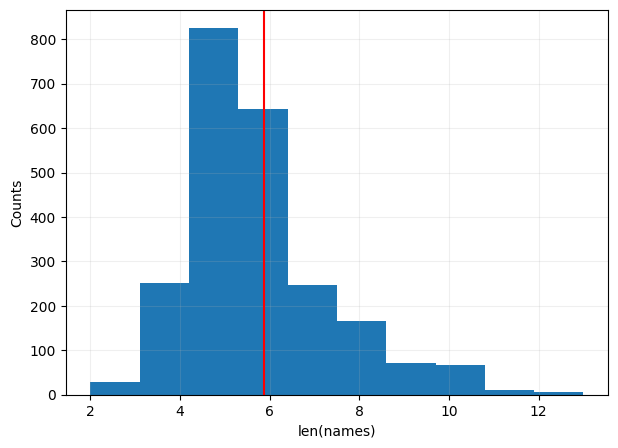

In [18]:
fig = plt.figure(figsize=(7, 5))
plt.hist([name[1] for name in length_name])
plt.grid(alpha=0.2)
plt.axvline(x=mean_length, color="red")
plt.xlabel("len(names)")
plt.ylabel("Counts")
plt.show()

### $N$-gram Analysis on the Turkish Names Dataset 

Let's count the unigrams of each character first,

In [19]:
def count_unigrams(names):
    # names is a list of names
    # count_unigrams returns a dictionary of character frequencies
    all_chars = []
    for name in names:
        all_chars += name
    # Create a dictionary based on the character counts
    char_counts = {}
    for c in all_chars:
        char_counts[c] = char_counts.get(c, 0) + 1
    return char_counts

In [20]:
unigram_sorted = dict(sorted(count_unigrams(names).items(), key=lambda item:item[1], reverse=True))

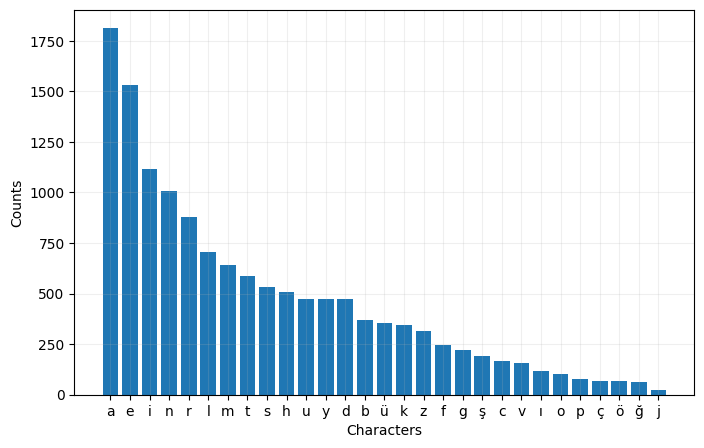

In [21]:
chars = unigram_sorted.keys()
freqs = unigram_sorted.values()

fig = plt.figure(figsize=(8, 5))
plt.bar(chars, freqs)
plt.grid(alpha=0.2)
plt.xlabel("Characters")
plt.ylabel("Counts")
plt.show()

Now, as we've discussed earlier let's introduce the start/end tokens and create a list of bigrams,

In [22]:
num_disp = 2
bigram_counts = {}
for i, name in enumerate(names):
    if i < num_disp:
        print(name)
    # Introducing the start/end tokens
    name = '.' + name + '.' 
    for c_prev, c in zip(name, name[1:]):
        if i < num_disp:
            print(c_prev + '->' + c)
        # Count bigrams
        bigram_counts[(c_prev, c)] = bigram_counts.get((c_prev, c), 0) + 1

hüsne
.->h
h->ü
ü->s
s->n
n->e
e->.
basiri
.->b
b->a
a->s
s->i
i->r
r->i
i->.


Let's visualize the counted bigrams in a matrix format as we did previously. Note that for the sake of presentation simplicity we will order the Turkish letters first, where the start/end token is the first element.

In [23]:
alphabet = "."
alphabet += "abcçdefgğhıijklmnoöprsştuüvyz"
alphabet

'.abcçdefgğhıijklmnoöprsştuüvyz'

In [24]:
# Preallocate a frequencies matrix
alphabet = list(alphabet)
C = np.zeros((len(alphabet), len(alphabet)), dtype="int")


for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        # Note that row (1st char), column (2nd char)
        C[i, j] = bigram_counts.get((alphabet[i], alphabet[j]), 0)

Let's plot matrix C using a heatmap,

In [25]:
def bigram_heatmap(C, figsize=(16, 16)):
    threshold = 0.7*( (np.max(C) + np.min(C)) / 2 )
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(C, cmap="hot")
    ax.set_xticks(range(len(alphabet)))
    ax.set_xticklabels(alphabet)
    ax.set_yticks(range(len(alphabet)))
    ax.set_yticklabels(alphabet)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            ax.text(j, i, f"({alphabet[i]}-{alphabet[j]})\n {C[i, j]:.2f}", color="white" if C[i, j].item() < threshold.item() else "black", fontsize=7, ha="center")
    plt.show()

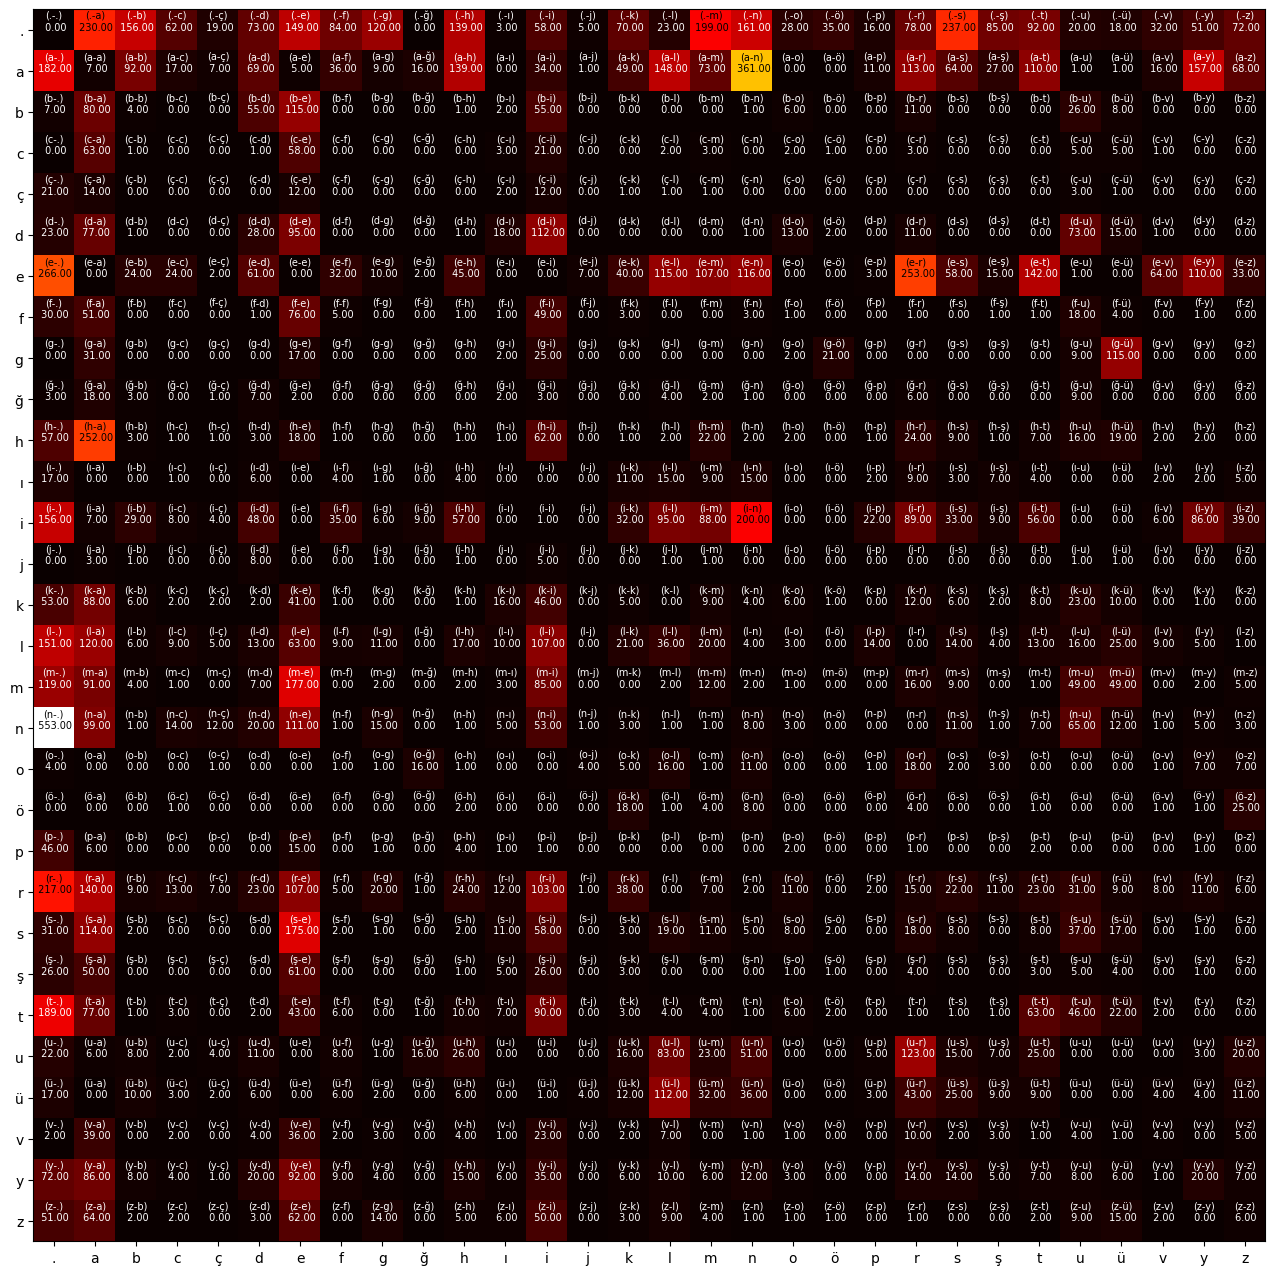

In [26]:
bigram_heatmap(C, figsize=(16, 16))

As can be seen from the matrix above, the first row represents all names that start with the character shown in each column. Similarly, the first column represents the names that end with the character shown in each row.
- For instance the most common first character in the names in the dataset is `s` since $\mathcal{C}(\texttt{●, s}) = 237$.


- Similarly, the most common last character is `n` since $\mathcal{C}(\texttt{n, ●}) = 553$.

Let's adjust our counts/frequency matrix to reflect the bigram probabilities using \eqref{eq:23}. We are starting with a simple example and then apply the same idea to the actual counts matrix.

In [27]:
x = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
x

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [28]:
row_sum = np.sum(x, axis=1, keepdims=True) # column-wise sum (axis=0) and row-wise sum (axis=1)
row_sum

array([[ 3],
       [12],
       [21]])

In [29]:
norm_x = x / row_sum
norm_x

array([[0.        , 0.33333333, 0.66666667],
       [0.25      , 0.33333333, 0.41666667],
       [0.28571429, 0.33333333, 0.38095238]])

In [30]:
norm_row_sum = np.sum(norm_x, axis=1)
norm_row_sum

array([1., 1., 1.])

Now, we can apply the same idea to the $\texttt{C}$ matrix,

In [31]:
P = C / np.sum(C, axis=1, keepdims=True)
np.sum(P, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Let's visualize the $\texttt{P}$ matrix after the row-wise normalization,

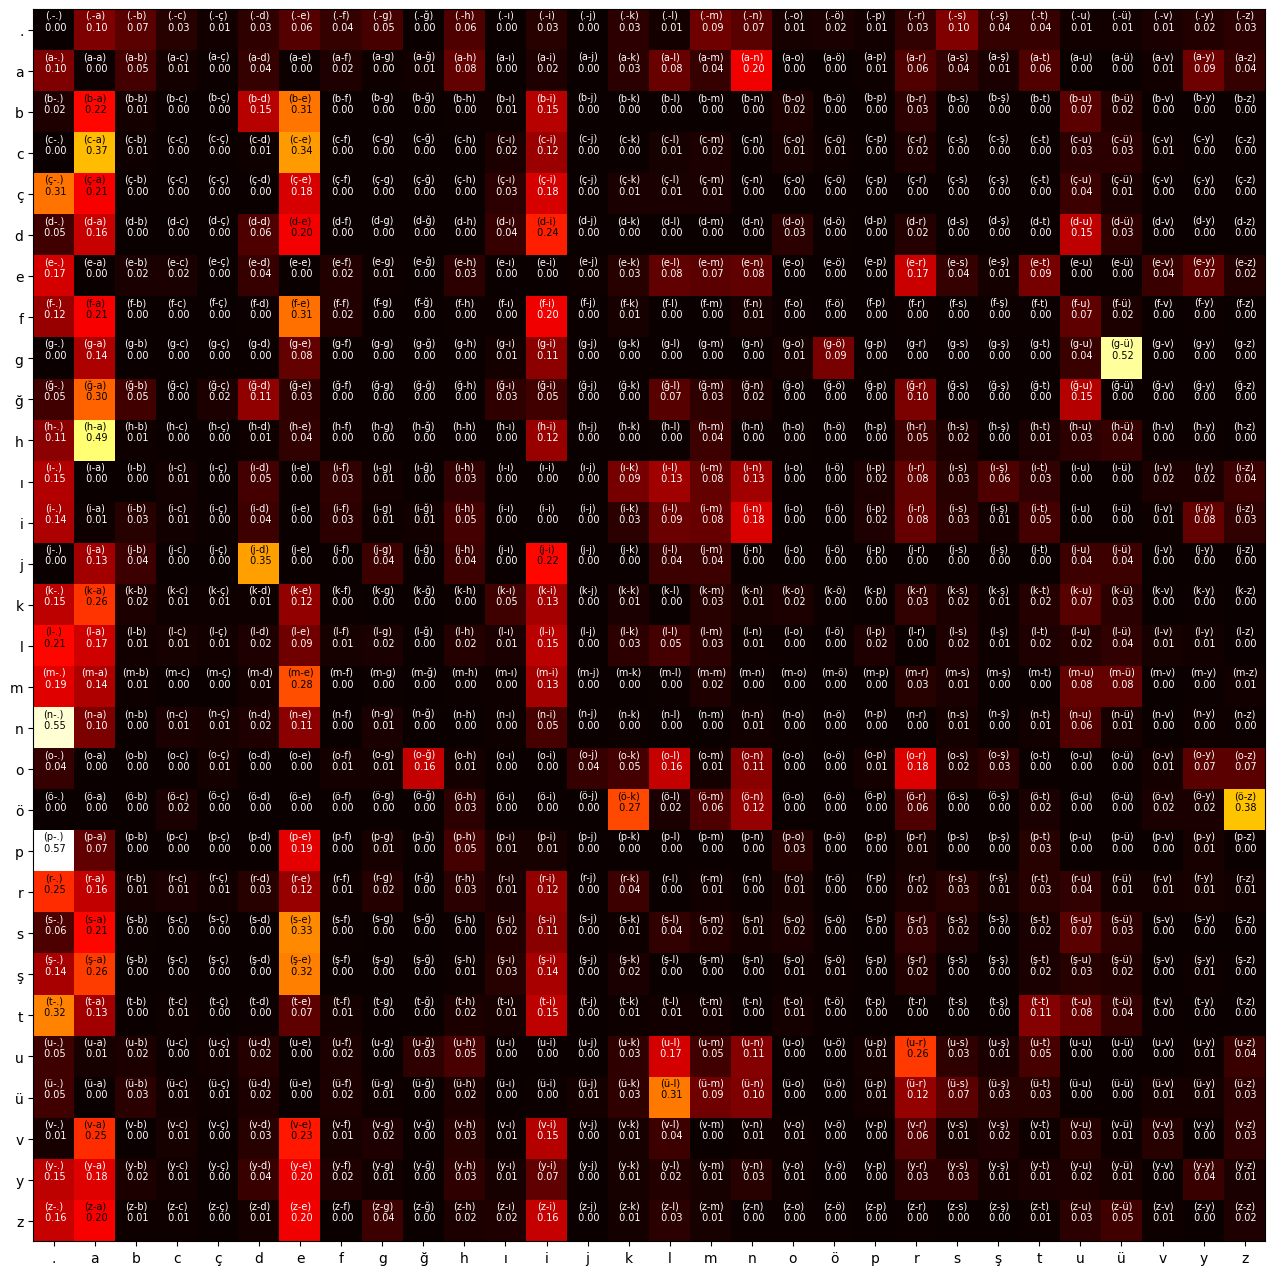

In [32]:
bigram_heatmap(P, figsize=(16, 16))

- Since we've calculated the **relative frequencies**, this represents the use of MLE for our corpus. For example, the character $\texttt{a}$ appears $1813$ times in a total of $2,315$ names. Its probability is therefore $1813/2315 = 0.7832$.  

- This value is not a universal probability for $\texttt{a}$ — in another corpus, a different character might be more frequent. However, within this dataset, it is the probability that makes the $1813$ occurrences of $\texttt{a}$ *most likely*.  

- In the next sections, we’ll refine the MLE approach to produce better probability estimates.

As an example, let's calculate the probability of names like $\texttt{emre}$ as follows, note that each cell indicates how many times the column character follows the row character:
\begin{align}
P(\texttt{emre}) &= P(\texttt{e} ~ | ~ ●)\times P(\texttt{m} ~ | ~ \texttt{e})\times P(\texttt{r} ~ | ~ \texttt{m})\times P(\texttt{e} ~ | ~ \texttt{r})\times P( ● ~ | ~ \texttt{e}) \\
& = 0.06 \times 0.07 \times 0.03 \times 0.12 \times 0.17 = 2.5704\times 10^{-6}
\end{align}

An interesting question here is that what would happen if we've designed a name generator, which would use the *most likely* option all the time?

In [33]:
def gen_most_likely_name(P, alphabet):
    ''' This function takes the probabilities matrix
    and the alphabet and returns the most likely name'''
    name = ['.']
    selected_idx = np.argmax(P[0, :])
    name.append(alphabet[selected_idx])
    while True:
        if alphabet[selected_idx] == '.':
            break
        selected_idx = np.argmax(P[selected_idx, :])
        name.append(alphabet[selected_idx])
    return ''.join(name)

In [34]:
print(f" Most likely name based on the relative frequency matrix: {gen_most_likely_name(P, alphabet)}")

 Most likely name based on the relative frequency matrix: .se.


Since the name selection is purely based on probabilities a two character name has been generated. However, from our Turkish names corpus we know that the average length of names is $5.88$ characters. Thus, let's update the function above with the minimum length constrain.

In [35]:
def gen_most_likely_name(P, alphabet):
    ''' This function takes the probabilities matrix
    and the alphabet and returns the most likely name'''
    name = ['.']
    selected_idx = np.argmax(P[0, :])
    name.append(alphabet[selected_idx])
    while True:
        if len(name) > 5 and alphabet[selected_idx] == '.':
            break
        selected_idx = np.argmax(P[selected_idx, :])
        name.append(alphabet[selected_idx])
    return ''.join(name)

In [36]:
print(f" Constrained most likely based on the relative frequency matrix: {gen_most_likely_name(P, alphabet)}")

 Constrained most likely based on the relative frequency matrix: .se.se.



As can be seen from the above generation the model will be repeating itself since each name is starting and ending with our special token `●`.

So what can be done here? 
- What is missing is the randomness!

- We should be able to use the probabilities but not every single time the maximum probability character should be picked!

- We can use the multinomial sampling function for that job.

We will be using PyTorch's `torch.multinomial()` function, which will return us the indices sampled from the bigram distribution. In order to make sure the results are reproducible we also will use a generator object.

In [37]:
nsamples = 10 # number of samples from multinomial distribution

In [129]:
g = torch.Generator().manual_seed(112)
p = torch.rand(3, generator=g)
p = p / sum(p)
p

tensor([0.0136, 0.1300, 0.8564])

You can see from the below function call that the normalized bogram counts (or relative frequencies) have been passed to the function along with the number of samples we want. The replacement flag is set to true since each of our trials are independent.

In [117]:
p = torch.Tensor(p)
idxs = torch.multinomial(p, num_samples=nsamples, replacement=True, generator=g)

In [118]:
p[idxs]

tensor([0.6070, 0.6070, 0.3427, 0.6070, 0.6070, 0.6070, 0.3427, 0.3427, 0.3427,
        0.6070])

Let's implement this into our $P$ matrix,

In [119]:
P = torch.Tensor(P)

In [120]:
def gen_multinomial_name(P, alphabet, g):
    ''' This function takes the probabilities matrix
    and the alphabet and returns the names based on the
    multinomial distribution P. The generator g is used for
    reproducibility. '''
    name = []
    sel_idx  = 0
    name.append(alphabet[sel_idx])
    while True:
        sel_idx = torch.multinomial(P[sel_idx, :], num_samples=1, replacement=True, generator=g).item()
        name.append(alphabet[sel_idx])
        if alphabet[sel_idx] == '.':
            break
    return ''.join(name)

In [128]:
num_names = 20 # generate this many bigram names
g = torch.Generator().manual_seed(112)
for i in range(num_names):
    print(gen_multinomial_name(P, alphabet, g))

.aheçusinelih.
.şe.
.m.
.gökme.
.hahanii.
.sışakan.
.ahaprmircasimet.
.hihaihalican.
.h.
.ne.
.hayheydozivefingulatfi.
.ecan.
.e.
.san.
.r.
.gul.
.meziyy.
.abevrol.
.nahamal.
.anencoğusahliy.


As can be seen from the above examples the generator is able to generate some semi-acceptable names such as `gökme`, `sışakan` 😂, `hihaihalican` 😂😂😂. Even though we've managed to realized the bigram name generation the generated names are not that impressive. Let's make sure that the bigram name generation works. In order to do that we will replace the $P$ matrix with a ones matrix which would essentially mean a **uniform distribution** across all the characters, meaning that each character will be equally likely.

In [134]:
P_uniform = torch.ones(P.shape)
num_names = 20 # generate this many bigram names
g = torch.Generator().manual_seed(112)
for i in range(num_names):
    print(gen_multinomial_name(P_uniform, alphabet, g))

.uhoçtsygjlzhgvsşmıgytmrhısgçoii.
.vışrkrzsdövprmprcğsugsiühovaietltcsilüjnğ.
.zgeheğdozpvpfıvgujcvfojecmçıezspnjröpçcdmsztgy.
.abbvüotznphdmalyogrncouscgölğy.
.pckhhlşösmbfvuhzküıyğbğsoızfyçgzyzpnğtçvpkılcrzrgizvnüggubfdtvvbıopsjmtözitğk.
.ıerogavölybdeyvhıkrgübooüslybzibr.
.flğtpöaptkozmşekikfazıışrıguycrhümkgalüp.
.dislzadıdsutgğntckonıhyrcjeçşrvkrec.
.jkakdhfğjsjnseüuktmf.
.malşnmhsrşmbhffçiylcsjeziauıolerşbyhumüthvgpvbgımeşatşgüzc.
.üejiıtmedcvsoyt.
.gtkrz.
.kdoibağjnnuujrsettujjplyhüuzıösüöslzanl.
.içybzfşjşakcoiuönbldsshçeldkhmkmlsifreszınojbeoeüfumdjödbçkhğsbhfşpbgmtnçödçujufağpaçrdrktvdmdüşoşfnphkhduüesnnzdks.
.memhpftrgğtnabetşbıhuzüaaüosoknbpvğsnçnkdıpösihğtyşürgerynyçcçüğlsklç.
.çasş.
.üodjdohb.
.byrvöjtpfıacğpömöcjjüydzlvşbgşresiojdtkj.
.dhü.
.bfvüadaıepytnycıköcibzaöğtidvphlölsüşhorois.


Now, by looking at the above names generated based on complete random guess, we can made sure that the bigram name generator works but it is not really a good generator 😂.

## Dealing with Small Numbers in Large $N$-gram Models